<a href="https://colab.research.google.com/github/Gutleyb/MSU.AI_waveforms/blob/main/Waveforms_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

## 1. Описание экспериментов и подготовка датасета

Был подготовлен датасет для обучения и тестирования нейронной сети. Он содержит данные об импульсах термостимулированной акустической эмиссии (ТАЭ) в экспериментах по термическому воздействию на искусственные гипсово-песчаные образцы. Было проведено 2 цикла нагрев-охлаждение для 5 образцов, отличающихся распределениями примешанного песка по размерам. Для каждого эксперимента исследователями были вручную размечены импульсы, оценка проводилась на основе параметров импульсов и характерных паттернов волновых форм.

Оценка на основе параметров импульсов включала в себя фильтрацию импульсов по амплитуде и каналу записи. Импульсы менее 35 дБ составляют существенную часть датасета и в большинстве случаев представляют собой заведомо шумовой сигнал. Во время эксперимента работают 3 пьезоэлектрических датчика, 2 из которых служат для отслеживания внешних помех при мониторинге развития разрушения, а 1 присоединен к акустическому волноводу, соединенному с образцом. Таким образом, только 1 датчик (канал регистрации) регистрирует импульсы ТАЭ.

Среди всех импульсов выбирались те, что записаны с нужного канала и имеют амплитуду более 35 дБ. Среди них исследователем были выбраны импульсы ТАЭ, которые являются полезным сигналом с наибольшей долей вероятности. После этого из оставшихся импульсов, включая зарегистрированные на других каналах записи и имевшие амплитуду менее 35 дБ, были выбраны такие, которые однозначно можно отнести к помехам.

События ТАЭ имеют, в основном, импульсный характер: быстрое нарастание амплитуды и быстрое затухание. Тем не менее, в результате переотражений сигнала затухание волновой формы зарегистрированного импульса ТАЭ может быть длительным. Для шумов характерны низкая частота сигнала, длительное время нарастания, ярко выраженное экспоненциальное затухание и аномальные значения амплитуд (выбросы).

Чаще события ТАЭ имеют амплитуды выше порога шума, однако при фильтрации по порогу амплитуды многие малоамплитудные события могут быть потеряны. С этим связано **главное практическое приложение исследования: эффективное выделение событий ТАЭ на основе волновой формы сигнала без отсечения основной массы импульсов по порогу регистрации от анализируемой группы**.

Особенности датасета и его использования в задаче:
* События разделены на 2 класса: сигнал и шум.
* Данные систематизированы по образцам (0-4) и по циклам нагрева (1-2).
* Для образца `GS0430C1` на этапе второго цикла нагрева регистрация волновых форм не осуществлялась. По этой причине для анализа доступно 9 экспериментов с размеченными данными.
* Образцы отличаются друг от друга масштабом кварцевых включений единого происхождения в гипсовом цементе одинакового состава. В результате, они представляют собой, по сути, вариации одной и той же модельной породы. После первого цикла температурного воздействия в структуре возможны физико-химические преобразования, связанные, прежде всего, с потерей связанной воды. С этой точки зрения, второй цикл нагрева может рассматриваться в качестве эксперимента с образцом "новой" породы. Этим обусловлено разбиение датасета на обучающую и тестовую выборки: **train & validation - I цикл**, **test - II цикл**. При таком подходе тестирование сети проводится на действительно новых данных с физической точки зрения, что позволяет оценить применимость метода для работы с данными других экспериментов, проводимых на нагревательной установке с образцами других горных пород.

## 2. Загрузка данных

Подключение библиотек и загрузка данных из Kaggle. Подключение к датасету, размещенному на Kaggle осуществляется через json-файл, размещенный на частном Google Disk.

In [ ]:
!pip install -q gdown

In [ ]:
import pandas as pd
import numpy as np
import json
import gdown
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
json_kaggle_id = '1BwnM6KBSvEONYOK_dmlBd0AzBZnwkaLC' # файл для Kaggle
json_output = 'kaggle.json'
gdown.download(f'https://drive.google.com/uc?id={json_kaggle_id}', json_output, quiet=False)
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets list --user gutleyb # проверяем, что датасет виден
!kaggle datasets download -d gutleyb/tae-dataset -p ./data --unzip # скачиваем датасет импульсов
!kaggle datasets files gutleyb/tae-dataset # смотрим названия файлов

Downloading...
From: https://drive.google.com/uc?id=1BwnM6KBSvEONYOK_dmlBd0AzBZnwkaLC
To: /content/kaggle.json
100%|██████████| 63.0/63.0 [00:00<00:00, 206kB/s]


Dataset URL: https://www.kaggle.com/datasets/gutleyb/tae-dataset
License(s): unknown
  0% 0.00/49.4M [00:00<?, ?B/s]
100% 49.4M/49.4M [00:00<00:00, 1.14GB/s]
Next Page Token = CfDJ8Ksq__M8KNdOsrtGDpOZ52U2Cp9Tmrs2EkfCj9yFozEq01zEFQoafehbOiBbiwaIXgA9fzEmMGN7u_T7rTHkn9mUICYPrgdzUU3kjGVh1R9xFz_ivS_Jhp6TzjUPUon7vRdkAUPaZf8S5mGtOAF1bWSncg
name                                 size  creationDate                
-------------------------------  --------  --------------------------  
TAE Dataset/GS0430C0_heat-1.npz  16717760  2025-11-21 21:11:34.104000  
TAE Dataset/GS0430C0_heat-1.txt     23366  2025-11-21 21:11:33.794000  
TAE Dataset/GS0430C0_heat-2.npz   9410956  2025-11-21 21:11:34.156000  
TAE Dataset/GS0430C0_heat-2.txt     12952  2025-11-21 21:11:33.979000  
TAE Dataset/GS0430C1_heat-1.npz  13782904  2025-11-21 21:11:34.079000  
TAE Dataset/GS0430C1_heat-1.txt     19205  2025-11-21 21:11:33.964000  
TAE Dataset/GS0430C2_heat-1.npz  12811556  2025-11-21 21:11:34.219000  
TAE Dataset/GS043

Функция распаковки отдельного эксперимента в список, содержащий label класса и волновую форму сигнала (5000 амплитуд).

In [ ]:
def download_single_exp(exp_name, stage):
    txt_path = '/content/data/TAE Dataset/' + exp_name + '_heat-' + str(stage) + '.txt'
    npz_path = '/content/data/TAE Dataset/' + exp_name + '_heat-' + str(stage) + '.npz'

    df = pd.read_csv(txt_path, sep="\t")
    waves = np.load(npz_path, allow_pickle=True)
    df = df[df['label'].isin([1, 2])] # оставляем классы 1 и 2

    dataset = []

    for _, row in df.iterrows():
        num = row['number']
        dataset.append((waves[str(int(num))], row['label'])) # ключ в npz всегда строка

    print(f'{exp_name}, цикл {stage}: {len(dataset)} импульса')

    return dataset

Функция подготовки датасета, содержащего данные нескольких экспериментов бзе разделения по образцам. Отдельно создается датасет, содержащий данные первого цикла нагрева, отдельно - второго.

In [ ]:
def download_dataset():
    exp_names = ['GS0430C0',
                 'GS0430C2',
                 'GS0430C3',
                 'GS0430C4',
                 'GS0430C1'] # C1 в конце для удобства. У него нет 2-го цикла нагрева

    stage = 1
    print(f'==Делаем DATASET (цикл нагрева {stage})==')
    dataset_1 = []
    for exp_name in exp_names:
        dataset = download_single_exp(exp_name, stage)
        dataset_1.extend(dataset)
    print('---')
    print(f'dataset_1 для цикла {stage}: {len(dataset_1)} импульса')
    print()

    stage = 2
    print(f'==Делаем DATASET (цикл нагрева {stage})==')
    dataset_2 = []
    for exp_name in exp_names[:-1]:
        dataset = download_single_exp(exp_name, stage)
        dataset_2.extend(dataset)
    print('---')
    print(f'dataset_2 для цикла {stage}: {len(dataset_2)} импульса')

    return dataset_1, dataset_2

Функция разбиения датасета на обучающую и валидационную выборки в формате:


*   X - numpy array волновых форм
*   y - numpy array лейблов класса



In [ ]:
from sklearn.model_selection import train_test_split

def data_split(dataset, names):
    X = np.array([wave for wave, label in dataset])
    y = np.array([int(label) - 1 for wave, label in dataset]) # приводим к виду 1/0: 0 - сигнал, 1 - шум
    print(f'X: {X.shape}. Пример X:')
    print(X[0:5])
    print(f'y: {y.shape}. Пример y:')
    print(y[0:10])

    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # учитываем баланс классов - должно быть поровну
    )
    print(f'X_{names[0]}: {X_train.shape}, y_{names[0]}: {y_train.shape}')
    print(f'X_{names[1]}: {X_test.shape}, y_{names[1]}: {y_test.shape}')

    return X_train, X_test, y_train, y_test

In [ ]:
dataset_1, dataset_2 = download_dataset()

==Делаем DATASET (цикл нагрева 1)==
GS0430C0, цикл 1: 468 импульса
GS0430C2, цикл 1: 408 импульса
GS0430C3, цикл 1: 858 импульса
GS0430C4, цикл 1: 580 импульса
GS0430C1, цикл 1: 504 импульса
---
dataset_1 для цикла 1: 2818 импульса

==Делаем DATASET (цикл нагрева 2)==
GS0430C0, цикл 2: 316 импульса
GS0430C2, цикл 2: 280 импульса
GS0430C3, цикл 2: 530 импульса
GS0430C4, цикл 2: 354 импульса
---
dataset_2 для цикла 2: 1480 импульса


Посмотрим на данные:

In [ ]:
X_train, X_val, y_train, y_val = data_split(dataset_1, ['train', 'val'])

X: (2818, 5000). Пример X:
[[-8. -4. -4. ...  2. -1.  6.]
 [ 5.  1. -7. ... 15. 14. 12.]
 [ 2.  3.  2. ... -4. -1. -1.]
 [-7. -7. -8. ...  1. -4. -8.]
 [ 9.  7.  2. ... -2. -9. -6.]]
y: (2818,). Пример y:
[1 0 0 1 0 0 0 0 0 0]
X_train: (2254, 5000), y_train: (2254,)
X_val: (564, 5000), y_val: (564,)


In [ ]:
X_test = np.array([wave for wave, label in dataset_2])
y_test = np.array([int(label) - 1 for wave, label in dataset_2])
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_test: (1480, 5000), y_test: (1480,)


Для корректного обучения нормализуем данные - каждую волновую форму отдельно.

In [ ]:
X_train = np.array([(x - x.mean()) / (x.std() + 1e-8) for x in X_train])
X_val = np.array([(x - x.mean()) / (x.std() + 1e-8) for x in X_val])
X_test = np.array([(x - x.mean()) / (x.std() + 1e-8) for x in X_test])

Функция для визуализации числа событий в тестовой и контрольной группе - для отслеживания дисбаланса классов.

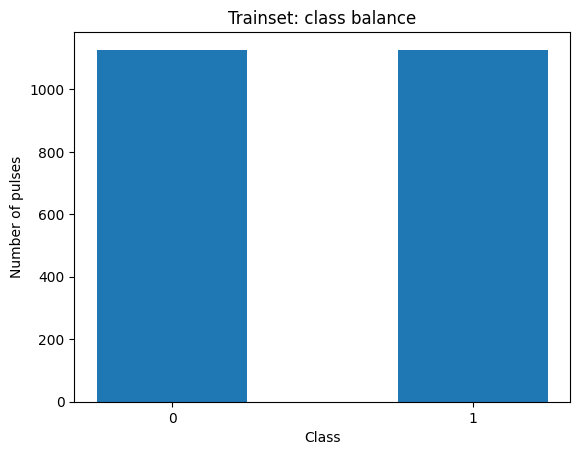

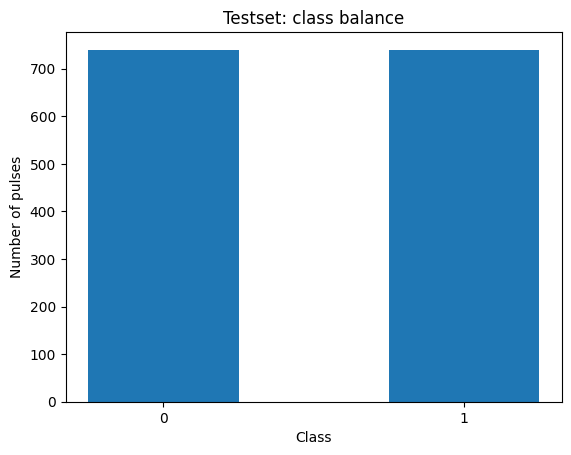

In [ ]:
def class_dist(labels, set_name='Trainset'):
    plt.hist(labels, bins=[-0.5, 0.5, 1.5], rwidth=0.5)
    plt.xticks([0, 1])
    plt.xlabel("Class")
    plt.ylabel("Number of pulses")
    plt.title(f'{set_name}: class balance')
    plt.show()

class_dist(y_train)
class_dist(y_test, set_name='Testset')

# Создание и обучение моделей

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [ ]:
# Установка seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

Функции для визуализации результатов обучения - зависимость Loss и Accuracy для обучающей и валидационной выборки в зависимости от эпохи обучения; вывод confusion matrix; построение ROC-кривой.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix, roc_curve

# Функции визуализации
def plot_training_history(train_loss, val_loss, train_acc, val_acc):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_loss, label='Train')
    ax1.plot(val_loss, label='Val')
    ax1.set_title('Model Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(train_acc, label='Train')
    ax2.plot(val_acc, label='Val')
    ax2.set_title('Model Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

def plot_roc_curve(y_true, y_proba, title=""):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve - {title}')
    plt.legend()
    plt.grid(True)
    plt.show()

Выбраны разные архитектуры моделей:
- MLP - полносвязная нейронная сеть. Выбор архитектуры обусловлен тем, что в рамках задачи важно выделить харакетрные особенности временного ряда на всем отрезке записи, для чего MLP модель является оптимальной.
- 1D CNN с 4 сверточными слоями - характеризуется меньшим числом параметров и большим вниманием к локальным признакам, то есть с помощью него возможно выделить харакетерные шаблоны для сигнала.
- В случае, если простые CNN не окажется достаточно хорошим вариантом для обучения, предполагается использовать более сложные архитектуры на основе CNN (например, Resnet).

Ниже универсальная функция для обучения MLP/CNN модели. Основные особенности:
- Функция потерь - BCELoss.
- Оптимизатор - Adam, lr = 0.0001.
- Xavier инициализация весов модели.
- Есть возможность задать параметр для L2 регуляризации.
- Возможность использования scheduler (параметр функции) - уменьшение lr при отсутствии улучшения результатов на валидационной выборке в течение 5 эпох.
- Ранее прерывание обучения - при отсутствии улучшения результатов на валидационной выборке в течение N эпох (N - параметр функции) обучение прерывается.

In [ ]:
# Универсальная функция обучения
def train_model(model, X_train, y_train, X_val, y_val,
                patience=15, l2_reg=0.0, use_scheduler=True, seed=42):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Определяем тип модели - нужно для добавления доп. измерения при работе с CNN
    is_cnn = any(isinstance(m, nn.Conv1d) for m in model.modules())

    if is_cnn:
        train_data = torch.FloatTensor(X_train).unsqueeze(1)
        val_data = torch.FloatTensor(X_val).unsqueeze(1)
    else:
        train_data = torch.FloatTensor(X_train)
        val_data = torch.FloatTensor(X_val)

    train_labels = torch.FloatTensor(y_train)
    val_labels = torch.FloatTensor(y_val)

    train_loader = DataLoader(TensorDataset(train_data, train_labels),
                             batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_data, val_labels),
                           batch_size=32)

    # Инициализация весов модели
    def init_weights(m):
        if isinstance(m, (nn.Conv1d, nn.Linear)):
            torch.manual_seed(seed)
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    model.apply(init_weights)

    # Оптимизатор + L2 регуляризация
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=l2_reg)

    criterion = nn.BCELoss()

    # Добавляем scheduler
    if use_scheduler:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                        patience=5, factor=0.5,
                                                        min_lr=1e-7)

    model.to(device)
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    best_val_loss = float('inf')
    no_improve = 0

    for epoch in range(100):
        # Train
        model.train()
        epoch_loss = correct = total = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x)

            loss = criterion(outputs.squeeze(), y)
            predicted = (outputs > 0.5).float()

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            correct += (predicted.squeeze().round() == y.round()).sum().item()
            total += y.size(0)

        train_loss.append(epoch_loss / len(train_loader))
        train_acc.append(correct / total)

        # Validation
        model.eval()
        epoch_val_loss = correct = total = 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)

                loss = criterion(outputs.squeeze(), y)
                predicted = (outputs > 0.5).float()

                epoch_val_loss += loss.item()
                correct += (predicted.squeeze().round() == y.round()).sum().item()
                total += y.size(0)

        current_val_loss = epoch_val_loss / len(val_loader)
        val_loss.append(current_val_loss)
        val_acc.append(correct / total)

        # Обновляем scheduler
        if use_scheduler:
            scheduler.step(current_val_loss)

        # Early stopping
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            no_improve = 0
            best_model = model.state_dict().copy()
        else:
            no_improve += 1

        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch+1}: Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, LR: {current_lr:.2e}')

    model.load_state_dict(best_model)
    return model, (train_loss, val_loss, train_acc, val_acc)

# Оценка модели
def evaluate_model(model, X, y, dataset_name=""):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    is_cnn = any(isinstance(m, nn.Conv1d) for m in model.modules())

    if is_cnn:
        data = torch.FloatTensor(X).unsqueeze(1)
    else:
        data = torch.FloatTensor(X)

    with torch.no_grad():
        outputs = model(data.to(device))

        y_proba = outputs.squeeze().cpu().numpy()
        y_pred = (y_proba > 0.5).astype(int)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred, zero_division=0)
    auc = roc_auc_score(y, y_proba)

    print(f"{dataset_name}: Acc: {accuracy:.3f}, Prec: {precision:.3f}, Rec: {recall:.3f}, AUC: {auc:.3f}")

    return {
        'y_true': y, 'y_pred': y_pred, 'y_proba': y_proba,
        'accuracy': accuracy, 'precision': precision, 'recall': recall, 'auc': auc
    }

# Основная функция
def run_model(model, X_train, y_train, X_val, y_val, X_test, y_test,
              model_name="Model", patience=15, l2_reg=0.0,
              use_scheduler=True, seed=42):

    # 1. Обучение
    print("\nОбучение")
    model, history = train_model(model, X_train, y_train, X_val, y_val,
                                patience, l2_reg, use_scheduler, seed)
    train_loss, val_loss, train_acc, val_acc = history

    # 2. Визуализация обучения
    print("\nГрафики")
    plot_training_history(train_loss, val_loss, train_acc, val_acc)

    # 3. Оценка
    print("\nОценка модели")
    datasets = [
        ("Train", X_train, y_train),
        ("Validation", X_val, y_val),
        ("Test", X_test, y_test)
    ]

    results = {}
    for name, X, y in datasets:
        results[name] = evaluate_model(model, X, y, name)

        # Визуализации для Validation и Test
        if name in ["Validation", "Test"]:
            plot_confusion_matrix(results[name]['y_true'], results[name]['y_pred'], f"{model_name} - {name}")
            plot_roc_curve(results[name]['y_true'], results[name]['y_proba'], f"{model_name} - {name}")

            print(f"\nClassification_report - {model_name} {name}:")
            print(classification_report(y, results[name]['y_pred'], target_names=['Class 0', 'Class 1']))

    return model, results

# Функция предсказания
def predict(model, X_new):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    is_cnn = any(isinstance(m, nn.Conv1d) for m in model.modules())

    if is_cnn:
        data = torch.FloatTensor(X_new).unsqueeze(1)
    else:
        data = torch.FloatTensor(X_new)

    with torch.no_grad():
        outputs = model(data.to(device))
        y_proba = outputs.squeeze().cpu().numpy()
        y_pred = (y_proba > 0.5).astype(int)

    print(f"Predictions: {len(X_new)} samples")
    print(f"Class 0: {sum(y_pred == 0)}, Class 1: {sum(y_pred == 1)}")

    return y_pred, y_proba

## Полносвязная нейронная сеть

In [ ]:
# Полносвязная нейронная сеть с 3 скрытыми слоями
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64), nn.LeakyReLU(), nn.BatchNorm1d(64), nn.Dropout(0.5),
            nn.Linear(64, 32), nn.LeakyReLU(), nn.BatchNorm1d(32), nn.Dropout(0.5),
            nn.Linear(32, 16), nn.LeakyReLU(), nn.Dropout(0.3),
            nn.Linear(16, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x).squeeze()


Обучение
Epoch 1: Train Loss: 0.7251, Val Loss: 0.3435, LR: 1.00e-04
Epoch 2: Train Loss: 0.5727, Val Loss: 0.3118, LR: 1.00e-04
Epoch 3: Train Loss: 0.5130, Val Loss: 0.3063, LR: 1.00e-04
Epoch 4: Train Loss: 0.4361, Val Loss: 0.2475, LR: 1.00e-04
Epoch 5: Train Loss: 0.4239, Val Loss: 0.2509, LR: 1.00e-04
Epoch 6: Train Loss: 0.3720, Val Loss: 0.2215, LR: 1.00e-04
Epoch 7: Train Loss: 0.3509, Val Loss: 0.2130, LR: 1.00e-04
Epoch 8: Train Loss: 0.3292, Val Loss: 0.2023, LR: 1.00e-04
Epoch 9: Train Loss: 0.2913, Val Loss: 0.1852, LR: 1.00e-04
Epoch 10: Train Loss: 0.2712, Val Loss: 0.1810, LR: 1.00e-04
Epoch 11: Train Loss: 0.2615, Val Loss: 0.1586, LR: 1.00e-04
Epoch 12: Train Loss: 0.2414, Val Loss: 0.1669, LR: 1.00e-04
Epoch 13: Train Loss: 0.2245, Val Loss: 0.1537, LR: 1.00e-04
Epoch 14: Train Loss: 0.2238, Val Loss: 0.1524, LR: 1.00e-04
Epoch 15: Train Loss: 0.2184, Val Loss: 0.1485, LR: 1.00e-04
Epoch 16: Train Loss: 0.2107, Val Loss: 0.1545, LR: 1.00e-04
Epoch 17: Train Loss: 0

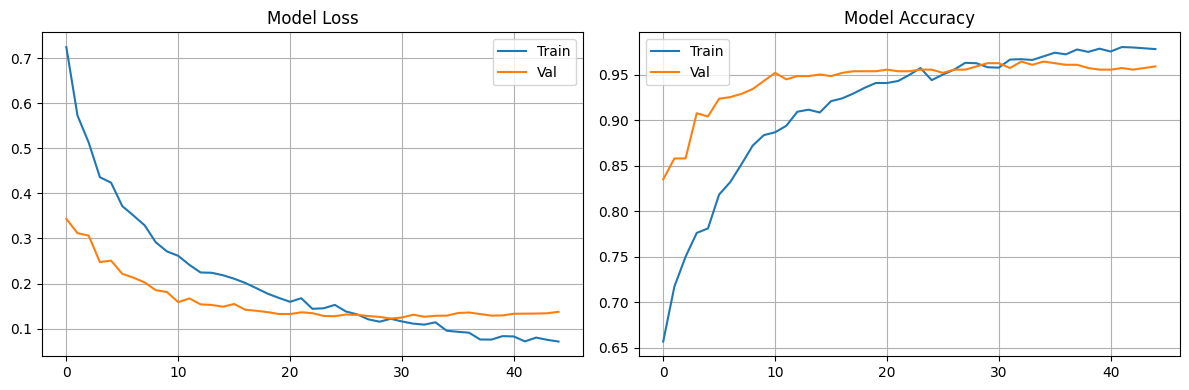


Оценка модели
Train: Acc: 0.998, Prec: 1.000, Rec: 0.996, AUC: 1.000
Validation: Acc: 0.959, Prec: 0.978, Rec: 0.940, AUC: 0.986


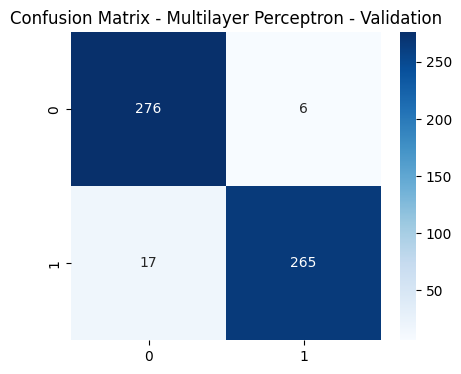

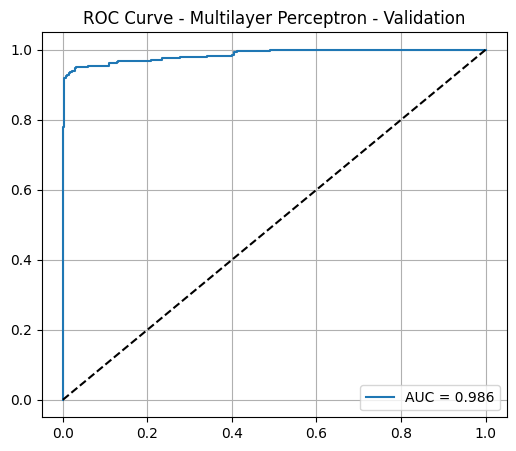


Classification_report - Multilayer Perceptron Validation:
              precision    recall  f1-score   support

     Class 0       0.94      0.98      0.96       282
     Class 1       0.98      0.94      0.96       282

    accuracy                           0.96       564
   macro avg       0.96      0.96      0.96       564
weighted avg       0.96      0.96      0.96       564

Test: Acc: 0.945, Prec: 0.975, Rec: 0.914, AUC: 0.989


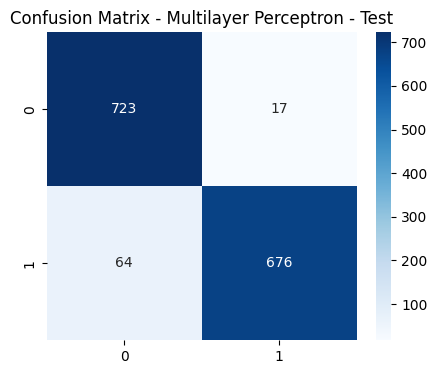

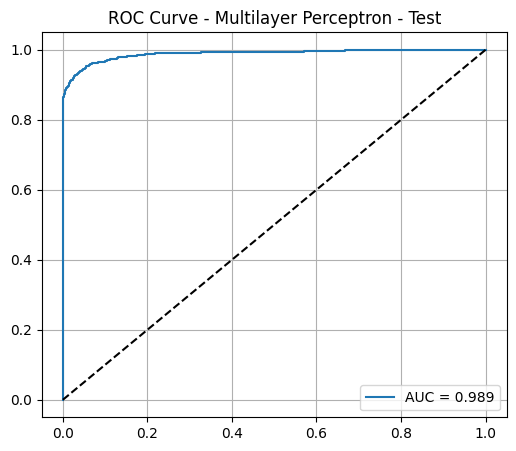


Classification_report - Multilayer Perceptron Test:
              precision    recall  f1-score   support

     Class 0       0.92      0.98      0.95       740
     Class 1       0.98      0.91      0.94       740

    accuracy                           0.95      1480
   macro avg       0.95      0.95      0.95      1480
weighted avg       0.95      0.95      0.95      1480



In [ ]:
mlp_model, mlp_model_results = run_model(MLP(input_dim=X_train.shape[1]), X_train, y_train, X_val, y_val, X_test, y_test,
                                model_name="Multilayer Perceptron",
                                patience=15, l2_reg=0, use_scheduler=True)

На тестовой выборке модель показала хороший результат - Accuracy 0.95.

## 1D CNN

In [ ]:
# 1D CNN
class CNN1D(nn.Module):
    def __init__(self, input_length=5000):
        super(CNN1D, self).__init__()

        self.features = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


Обучение
Epoch 1: Train Loss: 0.3357, Val Loss: 0.1925, LR: 1.00e-04
Epoch 2: Train Loss: 0.1992, Val Loss: 0.1601, LR: 1.00e-04
Epoch 3: Train Loss: 0.1707, Val Loss: 0.1265, LR: 1.00e-04
Epoch 4: Train Loss: 0.1454, Val Loss: 0.0980, LR: 1.00e-04
Epoch 5: Train Loss: 0.1240, Val Loss: 0.1028, LR: 1.00e-04
Epoch 6: Train Loss: 0.1298, Val Loss: 0.0878, LR: 1.00e-04
Epoch 7: Train Loss: 0.1154, Val Loss: 0.0773, LR: 1.00e-04
Epoch 8: Train Loss: 0.1005, Val Loss: 0.1047, LR: 1.00e-04
Epoch 9: Train Loss: 0.1101, Val Loss: 0.0804, LR: 1.00e-04
Epoch 10: Train Loss: 0.1106, Val Loss: 0.0725, LR: 1.00e-04
Epoch 11: Train Loss: 0.0920, Val Loss: 0.0873, LR: 1.00e-04
Epoch 12: Train Loss: 0.1030, Val Loss: 0.0631, LR: 1.00e-04
Epoch 13: Train Loss: 0.1000, Val Loss: 0.0694, LR: 1.00e-04
Epoch 14: Train Loss: 0.1082, Val Loss: 0.0692, LR: 1.00e-04
Epoch 15: Train Loss: 0.0993, Val Loss: 0.0613, LR: 1.00e-04
Epoch 16: Train Loss: 0.0994, Val Loss: 0.0594, LR: 1.00e-04
Epoch 17: Train Loss: 0

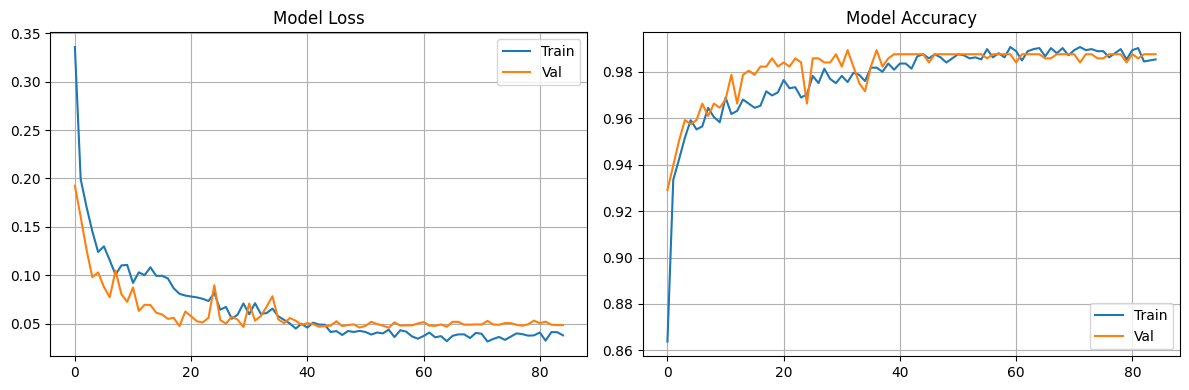


Оценка модели
Train: Acc: 0.994, Prec: 0.998, Rec: 0.990, AUC: 1.000
Validation: Acc: 0.988, Prec: 0.993, Rec: 0.982, AUC: 0.998


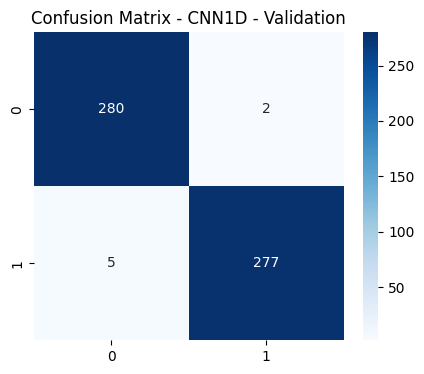

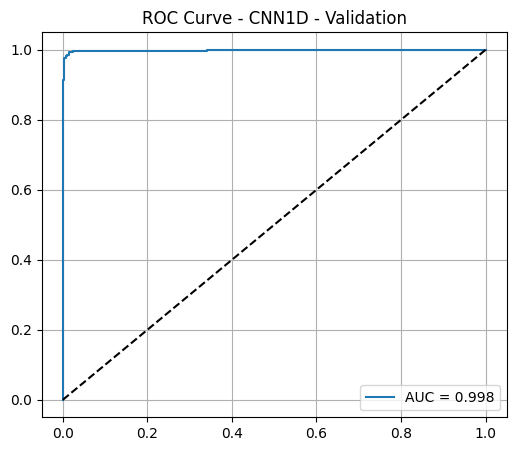


Classification_report - CNN1D Validation:
              precision    recall  f1-score   support

     Class 0       0.98      0.99      0.99       282
     Class 1       0.99      0.98      0.99       282

    accuracy                           0.99       564
   macro avg       0.99      0.99      0.99       564
weighted avg       0.99      0.99      0.99       564

Test: Acc: 0.976, Prec: 0.982, Rec: 0.970, AUC: 0.994


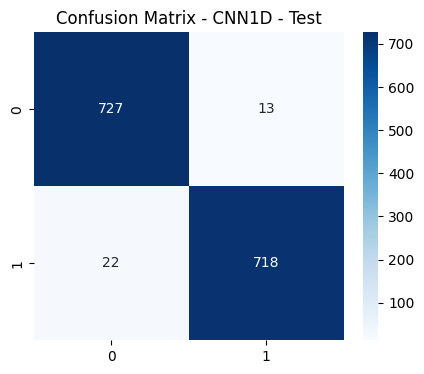

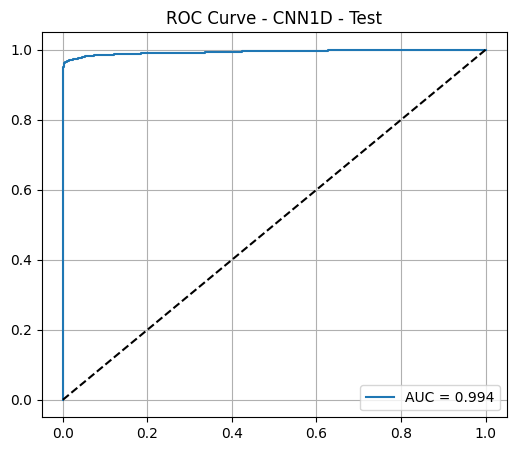


Classification_report - CNN1D Test:
              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.98       740
     Class 1       0.98      0.97      0.98       740

    accuracy                           0.98      1480
   macro avg       0.98      0.98      0.98      1480
weighted avg       0.98      0.98      0.98      1480



In [ ]:
cnn_model, cnn_model_results = run_model(CNN1D(input_length=X_train.shape[1]), X_train, y_train, X_val, y_val, X_test, y_test,
                                model_name="CNN1D",
                                patience=30, l2_reg=0, use_scheduler=True)

На тестовой выборке 1D CNN показала лучший результат - 0.98. По графикам Loss и Accuracy модель хорошо обучается.

# Тестирование на новых данных

Данные выше, на которых проводились обучение, валидация и тестирование, получены в эспериментах по нагреву гипсовых образцов. Проверим модели на данных экспериментов с другими образцами - **гранит (sAC)** и **базальт (sAB)**. Они могут давать отличный от гипса сигнал в процессе развития трещин. Кроме этого, форма шумового сигнала может отличаться в зависимости от условий выполнения эксперимента, так как эксперименты с гранитами и базальтами проводились в другое время в другом помещении.

sAB, цикл 1: 263 импульса
sAB, цикл 2: 175 импульса
---
dataset_1 для образца sAB: 438 импульса

sAC, цикл 1: 1332 импульса
sAC, цикл 2: 679 импульса
---
dataset_2 для образца sAC: 2011 импульса

X_test: (1648, 5000), y_test: (1648,)


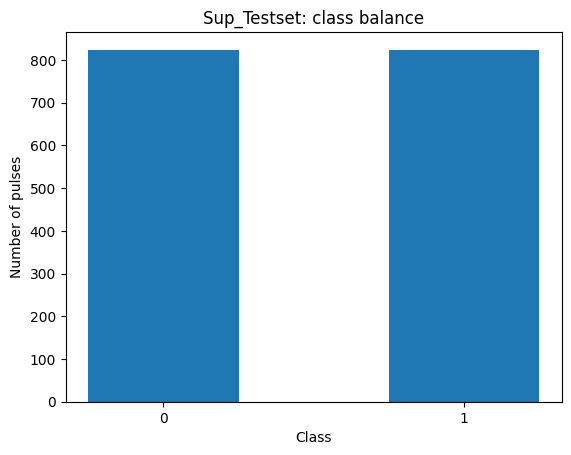

In [ ]:
# Загрузим доп контент

from imblearn.under_sampling import RandomUnderSampler

def download_sup_dataset():
    exp_names = ['sAB',
                 'sAC']
    dataset_1 = []
    exp_name = exp_names[0]
    for stage in [1, 2]:
        dataset = download_single_exp(exp_name, stage)
        dataset_1.extend(dataset)
    print('---')
    print(f'dataset_1 для образца {exp_name}: {len(dataset_1)} импульса')
    print()

    dataset_2 = []
    exp_name = exp_names[1]
    for stage in [1, 2]:
        dataset = download_single_exp(exp_name, stage)
        dataset_2.extend(dataset)
    print('---')
    print(f'dataset_2 для образца {exp_name}: {len(dataset_2)} импульса')
    print()

    # сразу сделаем данные для теста =====================

    dataset_2.extend(dataset_1)

    X_test = np.array([wave for wave, label in dataset_2])
    X_test = np.array([(x - x.mean()) / (x.std() + 1e-8) for x in X_test])
    y_test = np.array([int(label) - 1 for wave, label in dataset_2])

    rus = RandomUnderSampler(random_state=42) # сделаем undersampling ???
    X_test, y_test = rus.fit_resample(X_test, y_test)

    print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

    return X_test, y_test

X_sup_test, y_sup_test = download_sup_dataset()
class_dist(y_sup_test, set_name='Sup_Testset')

Данные сбалансированы, чтобы можно было смотреть на все метрики, в т.ч. Accuracy.


Модель Multilayer Perceptron
Predictions: 1648 samples
Class 0: 1441, Class 1: 207
Accuracy: 0.518
              precision    recall  f1-score   support

           0       0.51      0.89      0.65       824
           1       0.57      0.14      0.23       824

    accuracy                           0.52      1648
   macro avg       0.54      0.52      0.44      1648
weighted avg       0.54      0.52      0.44      1648



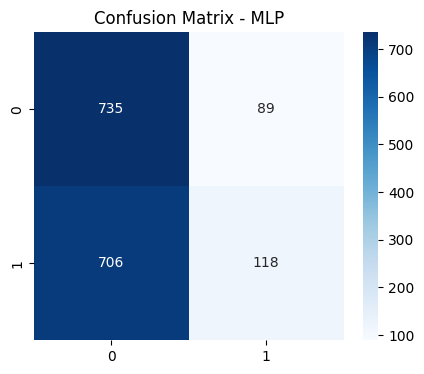


Модель CNN
Predictions: 1648 samples
Class 0: 890, Class 1: 758
Accuracy: 0.931
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       824
           1       0.97      0.89      0.93       824

    accuracy                           0.93      1648
   macro avg       0.93      0.93      0.93      1648
weighted avg       0.93      0.93      0.93      1648



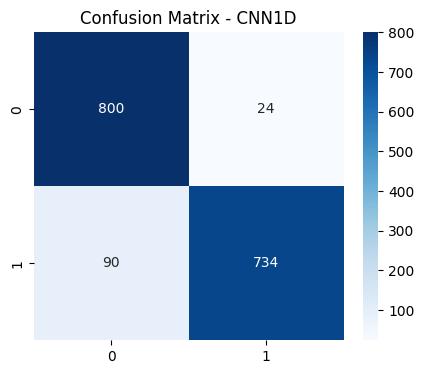

In [ ]:
models = [
    ("Multilayer Perceptron", mlp_model),
    ("CNN", cnn_model)
]

for name, model in models:
      print(f"\nМодель {name}")

      y_pred, y_proba = predict(model, X_sup_test)

      accuracy = accuracy_score(y_sup_test, y_pred)
      print(f"Accuracy: {accuracy:.3f}")
      print(classification_report(y_sup_test, y_pred))
      plot_confusion_matrix(y_sup_test, y_pred, title=f"{type(model).__name__}")

На новых данных MLP показала плохой результат - большую часть сигналов она относит к классу 0 (полезный сигнал). Это связанно с особенностями формы шумового сигнала в проводимых экспериментах - она отличается от формы шума в экспериментах с гипсом.
CNN при этом справляется с задачей с Accuracy 0.93, что является приемлемым результатом.